In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from math import *

In [86]:
dt = 1
g = 9.81

Q_covariance = 1.0
R_covariance = 1.0

In [103]:
def linearF(X):
    return np.array([[1, dt], [0, 0]])

# Predict state from the previous state estimate
# This is the system model
def f(X, u = 0):
    return np.array([X[0] + X[1]*dt, X[1] + u*dt]).T

# JacobianL dell{h()}/dell{x} evaluated at the current state
# 3x2 matrix that maps state-space into observation-space
def linearH(X):
    theta = X[0]
    H = np.array([[g*sin(theta), 0],[g*cos(theta), 0], [0, 1]])

    return H

def rawAngle(sensor_reading):
    return atan2(abs(sensor_reading[0]), abs(sensor_reading[1]))

# Predict measurement from the state estimate
# This is the sensor model
def h(X):
    theta = X[0]
    dtheta = X[1]

    return np.array([-g*cos(theta), g*sin(theta), dtheta])

# "Real sensor". Here it's simulated
def sensor(X):
    theta = X[0]
    dtheta = X[1]

    perfect_measurement = np.array([-g*cos(theta), g*sin(theta), dtheta]).T
    gaussian_noise = np.array([np.random.normal(0, R_covariance), np.random.normal(0, R_covariance), np.random.normal(0, R_covariance)])

    return perfect_measurement + gaussian_noise

In [104]:
# Initial state theta, dtheta...
x1, dx1 = 0,0

X = np.array([x1, dx1]).T

F = linearF(X)

Q = np.eye(2) * Q_covariance
R = np.eye(3) * R_covariance

P = np.eye(2) * 10

# Initial state estimate, might be wrong
X_k_1 = np.array([0, 0])
P_k_1 = P

# For plotting
num_steps = 100
Xs = np.zeros((2, num_steps))
Xs_actual = np.zeros((2,num_steps))
sensor_readings = np.zeros((num_steps))
Ps = np.zeros((2,num_steps))
ts = np.zeros(num_steps)

for i, t in enumerate(ts):
    # Simulation. This is the "real" system
    X = f(X, u=sin(i/9.0))

    # Predict
    X_k = f(X_k_1)

    F_k = linearF(X_k_1)
    P_k = F_k @ P_k_1 @ F_k.T + Q

    # Update
    sensor_reading = sensor(X)
    y_k = sensor_reading - h(X_k)

    H_k = linearH(X_k)
    S_k = H_k @ P_k @ H_k.T + R

    K_k = P_k @ H_k.T @ np.linalg.inv(S_k)


    X_k_k = X_k + K_k @ y_k

    P_k_k = (np.eye(2) - K_k @ H_k) @ P_k

    # Update vars for next loop
    X_k_1 = X_k_k
    P_k_1 = P_k_k

    # Update values for plotting
    ts[i] = i*dt
    Xs_actual[:,i] = X
    Xs[:,i] = X_k

    # print(sensor_reading)
    sensor_readings[i] = sensor_reading[-1]

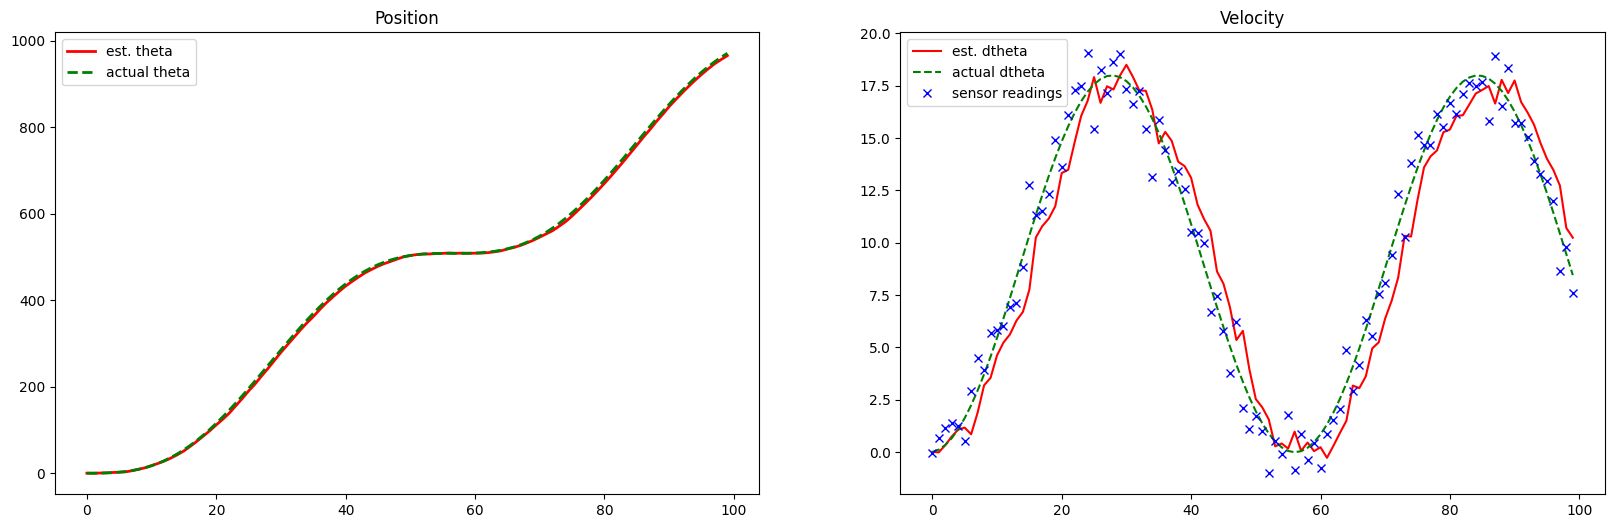

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].set_title("Position")
ax[0].plot(ts, Xs[0], 'r' , label='est. theta', linewidth=2)
ax[0].plot(ts, Xs_actual[0], 'g--', label='actual theta', linewidth=2)
# ax[0].plot(ts, sensor_readings[0], 'bx', label='sensor readings')
ax[0].legend()

ax[1].set_title("Velocity")
ax[1].plot(ts, Xs[1], 'r', label='est. dtheta')
ax[1].plot(ts, Xs_actual[1], 'g--', label='actual dtheta')
ax[1].plot(ts, sensor_readings, 'bx', label='sensor readings')
ax[1].legend()